In [2]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

def calpu(x):
    return np.percentile(x,85)
def calpd(x):
    return np.percentile(x,15)

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

In [3]:
h=0.6777

In [4]:
# GIZMO run
GIZMO=np.load('./data/GIZMO_Mbh_snap_128-with_BH-info.npy')
GIZMO.shape
##ReginIDs[0] HIDs[1] HostID[2] Mvir(3) Xc(4)   Yc(5)   Zc(6)  Rvir(7) fMhires(8) cNFW (9) Mgas200[10] M*200[11] M500[12]  R500[13] fgas500[14] f*500[15]
## need to add M*30[16] M*50[17] M*0.1R500[18] sigma_* s30[19], s50[20], s0.1[21]  
#  MaxM_BH 30kpc[22] 50kpc[23] 0.1R500[24]; radius to center BH 30kpc[25] 50kpc[26] 0.1R500[27]

(4793, 28)

In [5]:
# G3X = np.load('../BCG/data/G3X_M200m_snap_128-info.npy')
#ReginIDs[0] HIDs[1] Mvir(2) Xc-Zc(3-5) Rvir(6) fMhires(7) cNFW (8) Mgas200[9] M*200[10] M500[11] R500[12] fgas500[13] 
# f*500[14] BCG30[15], 50[16], 0.1R500[17]
G3X = np.load('./data/G3X_Mbh_snap_128-with_BH-info.npy')
G3X.shape
##ReginIDs[0] HIDs[1] HostID[2] Mvir(3) Xc(4)   Yc(5)   Zc(6)  Rvir(7) fMhires(8) cNFW (9) Mgas200[10] M*200[11] M500[12]  R500[13] fgas500[14] f*500[15]
## need to add M*30[16] M*50[17] M*0.1R500[18] sigma_* s30[19], s50[20], s0.1[21]  
#  MaxM_BH 30kpc[22] 50kpc[23] 0.1R500[24]; radius to center BH 30kpc[25] 50kpc[26] 0.1R500[27]

(5312, 28)

In [6]:
MUSIC = np.load('../BCG/data/MUSIC_M200m_snap_017-info.npy')
#ReginIDs[0] HIDs[1] Mvir(2) Xc-Zc(3-5) Rvir(6) fMhires(7) cNFW (8) M500[9] R500[10] fgas500[11] f*500[12] BCG30[13], 50[14], 0.1R500[15]

In [7]:
Kravtsov18 = loadtxt("/home2/weiguang/Project-300-Clusters/theoretical-check/baryonic-fraction-M500/KRAVTSOV2018.txt", usecols=([1,2,3,4,5,6,7,8]))
# CL name[0]   R500 kpc[1]   M500 10^14 Msun[2]   M* <30kpc 10^11Msun[3]    M* <50kpc[4]    
#   M* <50kpc[5]    M* <0.05R500[6]   M* <0.1R500[7]    M* <0.25R500[8

In [26]:
Kravtsov18

array([[1.539e+03, 1.560e+01, 5.180e+00, 7.610e+00, 9.610e+00, 1.021e+01,
        1.463e+01, 2.169e+01],
       [1.387e+03, 1.030e+01, 1.044e+01, 1.525e+01, 1.884e+01, 1.874e+01,
        2.535e+01, 3.409e+01],
       [1.235e+03, 7.000e+00, 7.120e+00, 9.470e+00, 1.091e+01, 1.038e+01,
        1.330e+01, 2.176e+01],
       [1.196e+03, 5.340e+00, 3.850e+00, 5.290e+00, 6.190e+00, 5.760e+00,
        8.140e+00, 1.270e+01],
       [8.730e+02, 2.350e+00, 3.670e+00, 4.780e+00, 5.560e+00, 4.480e+00,
        6.110e+00, 7.800e+00],
       [8.400e+02, 1.860e+00, 4.350e+00, 6.050e+00, 7.160e+00, 5.450e+00,
        7.680e+00, 1.040e+01],
       [7.480e+02, 1.340e+00, 4.710e+00, 6.750e+00, 8.200e+00, 5.550e+00,
        8.480e+00, 1.084e+01],
       [5.680e+02, 4.600e-01, 4.590e+00, 5.990e+00, 6.870e+00, 4.450e+00,
        6.330e+00, 8.480e+00],
       [5.680e+02, 4.700e-01, 6.760e+00, 8.300e+00, 9.120e+00, 6.580e+00,
        8.630e+00, 1.038e+01]])

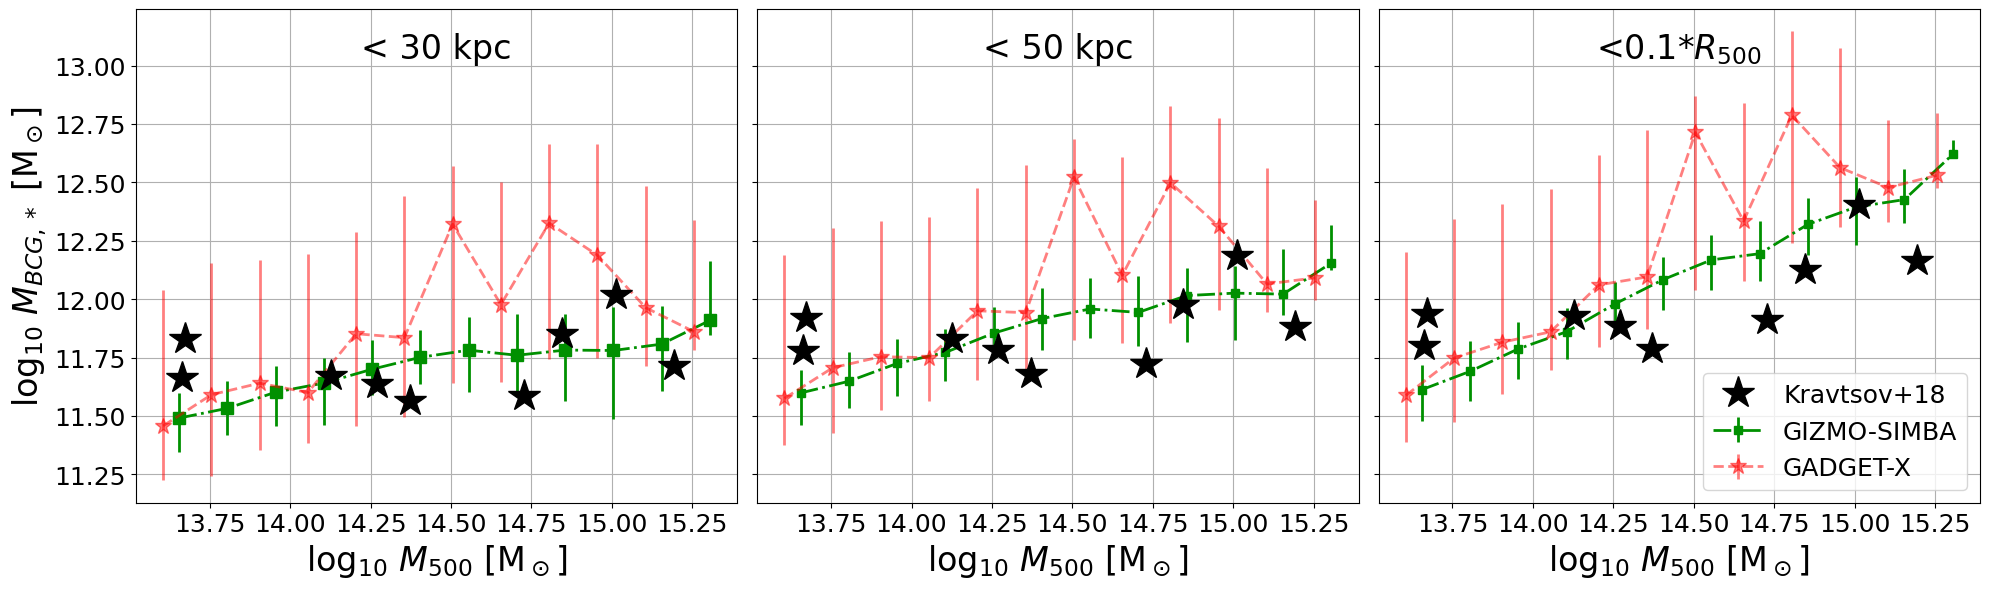

In [13]:
f, (ax1, ax2, ax3) = subplots(1, 3, sharey=True, figsize=(20,6))
# f.set_figheight = 6; f.set_figweight = 20

mlim=[13.53,15.35]
nbn=np.arange(mlim[0],mlim[1],0.15); xx=(nbn[1:]+nbn[:-1])/2
nbnz=nbn+0.05; xxz=xx+0.05

ax1.plot(np.log10(Kravtsov18[:,1]*1.0e14), np.log10(Kravtsov18[:,2]*1.0e11), 'k*', ms=24, zorder=10, mfc='k',
     label='Kravtsov et al. 2018')

# ids=GIZMO[:,12]>10
x=np.log10(GIZMO[:,12]/h)
myp=np.log10(GIZMO[:,16]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbnz)
ax1.errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=2,ls="-.", ms=8,zorder=8, label="GIZMO-SIMBA")

x=np.log10(G3X[:,12]*1.0e10/h)
myp=np.log10(G3X[:,16]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
ax1.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['red'],lw=2,ls="--", ms=12,zorder=8, label="GADGET-X",alpha=0.5)

# x=np.log10(MUSIC[:,9]*1.0e10/h)
# myp=np.log10(MUSIC[:,13]/h)
# pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
# pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
# pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
# ax1.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#          marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=8, label="GADGET-MUSIC")

ax1.text(0.5,0.9,'< 30 kpc',transform=ax1.transAxes, horizontalalignment='center', fontsize=24)

# yscale('log'); xscale('log')
# ylim(1.0e10,8.0e12); xlim(1.0e13, 4e15)
ax1.set_ylabel('$\log_{10}\ M_{BCG, *}\ [{\\rm M}_\odot]$', fontsize=24); ax1.set_xlabel("$\log_{10}\ M_{500}\ [{\\rm M}_\odot]$", fontsize=24)


ax2.plot(np.log10(Kravtsov18[:,1]*1.0e14), np.log10(Kravtsov18[:,3]*1.0e11), 'k*', ms=24, zorder=10, mfc='k',
     label='Kravtsov et al. 2018')

x=np.log10(GIZMO[:,12]/h)
myp=np.log10(GIZMO[:,17]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbnz)
ax2.errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=2,ls="-.", ms=6,zorder=8, label="GIZMO-SIMBA")

x=np.log10(G3X[:,12]*1.0e10/h)
myp=np.log10(G3X[:,17]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
ax2.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['red'],lw=2,ls="--", ms=12,zorder=8, label="GADGET-X",alpha=0.5)

# x=np.log10(MUSIC[:,9]*1.0e10/h)
# myp=np.log10(MUSIC[:,14]/h)
# pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
# pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
# pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
# ax2.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#          marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=8, label="GADGET-MUSIC")

ax2.text(0.5,0.9,'< 50 kpc', transform=ax2.transAxes,horizontalalignment='center',  fontsize=24)

# yscale('log'); xscale('log')
# ylim(1.0e10,8.0e12); xlim(1.0e13, 4e15)
ax2.set_xlabel("$\log_{10}\ M_{500}\ [{\\rm M}_\odot]$", fontsize=24)
# yticks([],[])


ax3.plot(np.log10(Kravtsov18[:,1]*1.0e14), np.log10(Kravtsov18[:,6]*1.0e11), 'k*', ms=24, zorder=10, mfc='k',
     label='Kravtsov+18')

x=np.log10(GIZMO[:,12]/h)
myp=np.log10(GIZMO[:,18]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbnz)
ax3.errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=2,ls="-.", ms=6,zorder=8, label="GIZMO-SIMBA")

x=np.log10(G3X[:,12]*1.0e10/h)
myp=np.log10(G3X[:,18]/h)
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
ax3.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['red'],lw=2,ls="--", ms=12,zorder=8, label="GADGET-X",alpha=0.5)

# x=np.log10(MUSIC[:,9]*1.0e10/h)
# myp=np.log10(MUSIC[:,15]/h)
# pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
# pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
# pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
# ax3.errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#          marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=-8, label="GADGET-MUSIC")

# yscale('log'); xscale('log')
# ylim(1.0e10,8.0e12); xlim(1.0e13, 4.0e15)
ax3.text(0.5,0.9,'<0.1*$R_{500}$', transform=ax3.transAxes, horizontalalignment='center', fontsize=24); 
ax3.set_xlabel("$\log_{10}\ M_{500}\ [{\\rm M}_\odot]$", fontsize=24)
ax3.legend(loc=4, fontsize=18)
ax3.grid()
ax2.grid()
ax1.grid()

tight_layout()
savefig("./plots/BCG-halo-mass-relation.pdf",dpi=300)

# study projection effects

In [6]:
Gzp=np.load('./data/GIZMO_Mbh_snap_128-projection.npy')
Gzp.shape
##ReginIDs[0] HIDs[1] HostID[2] Mvir(3) Xc(4)   Yc(5)   Zc(6)  Rvir(7) fMhires(8) cNFW (9) Mgas200[10] M*200[11] M500[12]  R500[13] fgas500[14] f*500[15]
    ## need to add M*30[16] M*50[17] M*0.1R500[18] projected M*30[19] M*50[20] M*0.1R500[21]

(4793, 22)

1.178068885087311 1.1278916327378075 1.0765546697238655 1.2464220080327406
1.1405646713516417 1.100597807779489 1.058797753902578 1.2038508665622674
1.1351156503030737 1.104994047443594 1.065859125484339 1.1925982089140843


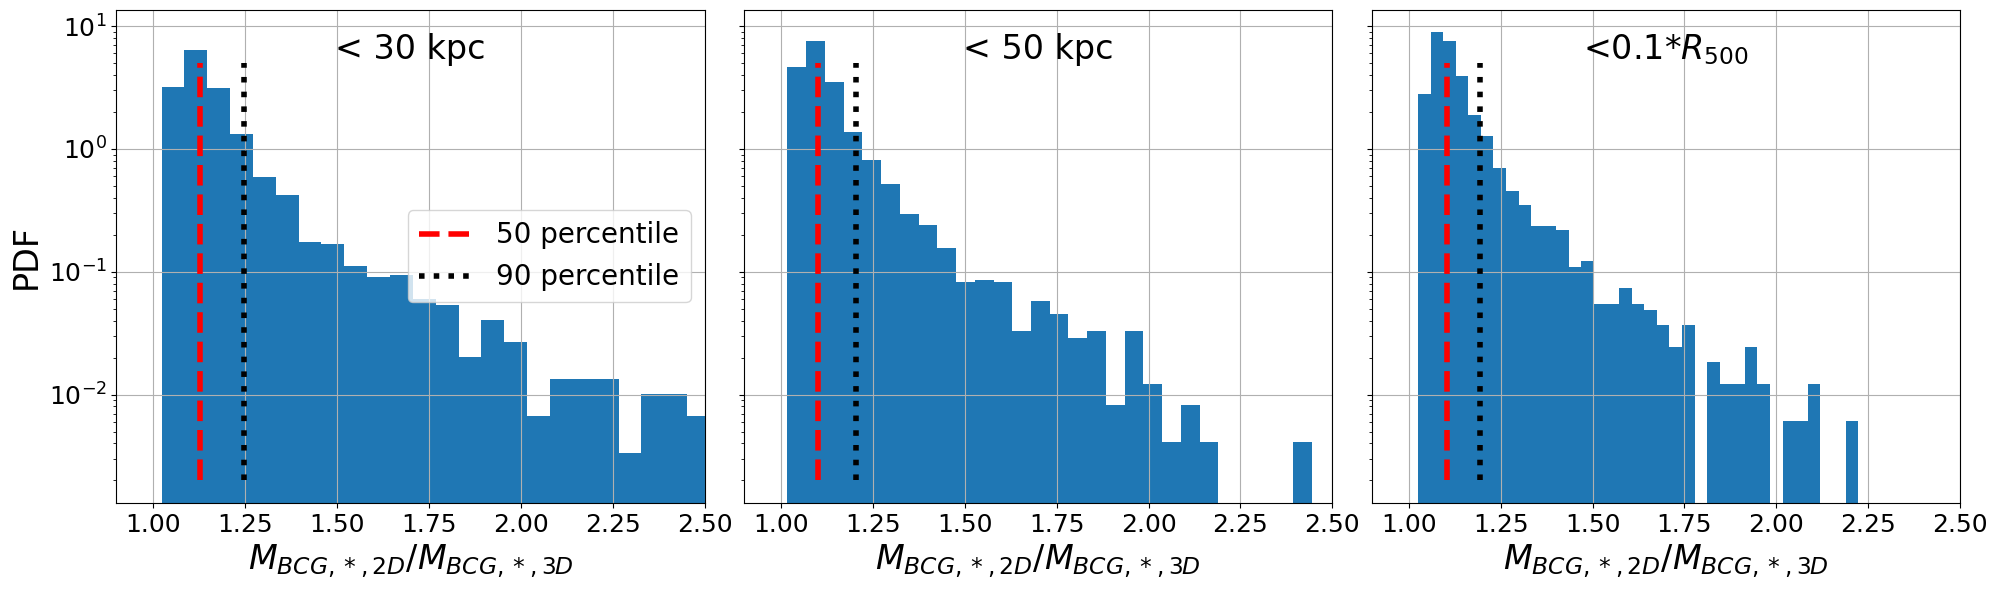

In [7]:
f, (ax1, ax2, ax3) = subplots(1, 3, sharey=True, sharex=True, figsize=(20,6))
data=Gzp[:,19]/Gzp[:,16]
ax1.hist(data,bins=90,density=True)
print(np.mean(data), np.median(data), calpd(data),calpu(data))
ax1.plot([np.median(data),np.median(data)],[0.002,5],'r--',lw=4, label='50 percentile')
ax1.plot([calpu(data),calpu(data)],[0.002,5],'k:',lw=4, label='90 percentile')
ax1.set_yscale('log')
ax1.set_xlim(0.9,2.5)
ax1.text(0.5,0.9,'< 30 kpc',transform=ax1.transAxes, horizontalalignment='center', fontsize=24)
ax1.set_ylabel('PDF', fontsize=24); ax1.set_xlabel("$M_{BCG, *, 2D} / M_{BCG, *, 3D}$", fontsize=24)
ax1.legend(loc='center right',fontsize=20)

data=Gzp[:,20]/Gzp[:,17]
ax2.hist(data,bins=50,density=True)
print(np.mean(data), np.median(data), calpd(data),calpu(data))
ax2.plot([np.median(data),np.median(data)],[0.002,5],'r--',lw=4)
ax2.plot([calpu(data),calpu(data)],[0.002,5],'k:',lw=4)
ax2.set_yscale('log')
ax2.text(0.5,0.9,'< 50 kpc',transform=ax2.transAxes, horizontalalignment='center', fontsize=24)
ax2.set_xlabel("$M_{BCG, *, 2D} / M_{BCG, *, 3D}$", fontsize=24)
# ax2.set_xlim(0.5,2.5)

data=Gzp[:,21]/Gzp[:,18]
ax3.hist(data,bins=50,density=True)
print(np.mean(data), np.median(data), calpd(data),calpu(data))
ax3.plot([np.median(data),np.median(data)],[0.002,5],'r--',lw=4)
ax3.plot([calpu(data),calpu(data)],[0.002,5],'k:',lw=4)
ax3.set_yscale('log')
# ax3.set_xlim(0.5,2.5)
ax3.text(0.5,0.9,'<0.1*$R_{500}$',transform=ax3.transAxes, horizontalalignment='center', fontsize=24)
ax3.set_xlabel("$M_{BCG, *, 2D} / M_{BCG, *, 3D}$", fontsize=24)
ax3.grid()
ax2.grid()
ax1.grid()

tight_layout()
savefig("./plots/BCG-projection.pdf",dpi=300)

In [30]:
legend?

Signature: legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting the 